In [1]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [2]:
url = 'https://www.nytimes.com/interactive/2020/05/24/us/us-coronavirus-deaths-100000.html'
response = requests.get(url)

In [3]:
print(response)  # if 200, it went through

<Response [200]>


In [4]:
soup = BeautifulSoup(response.text, 'html.parser')

In [5]:
t1000=soup.findAll('div', attrs={'class':"g-obit" })

In [6]:
txt=[]
for t in t1000:
    ddate = t.find('div', class_ = "g-obit")
    desc = t.find('div', class_ = 'g-obit-inner').text
   # desc = t.find('div', class_ = 'g-obit-inner')
    desc = desc.replace('”','').replace('.\n','_CHK_').replace('\n','').replace('“','')
    txt.append(desc)
   #print(ddate)
   # print(desc)

In [7]:
df0 = pd.DataFrame(txt ,columns=['raw'])
df = df0.copy()

## data wrangling

In [8]:
df[['memo','pinf']] = df.raw.str.split('_CHK_',1,expand = True)
df.pinf = df.pinf.str.replace(', Sr.',' Sr.')
df.pinf = df.pinf.str.replace('_CHK_','')
df[['name','age','loca']] = df.pinf.str.split(',',2,expand = True)
df[['city_county','state_temp']] = df.loca.str.split(',',1,expand = True)
df.state_temp = df.state_temp.str.replace('.','')

df.state_temp.isnull().sum()
sum(df[df.state_temp.isnull()].loca == df[df.state_temp.isnull()].city_county)

ls0=df[df.state_temp.isnull()].city_county.unique().tolist()
ls1=df[df.state_temp.notnull()].state_temp.unique()

ns0 =['CA', 'IL', 'LA', 'NJ', 
       'WA', 'NY', 'WA', 'MI',
       'NY', 'CO', 'MA', 'IN',
       'LA', 'MI', 'PA', 'UT', 'TN',
       'FL', 'MD', 'IN', 'VT', 'TN',
       'CA', 'WI', 'CO', 'CA',
       'PA', 'MN', 'MD', 'NE', 'NV',
       'MA', 'PA', 'WI', 'NY', 'CA',
       'AL', 'IA', 'TX', 'IA', 'ND',
       'OH', 'ID', 'VA', 'NV', 'KY',
       'CT', 'NC', 'AZ', 'GA',
       'FL', 'NM', 'VA', 'OH']
ns1 = ['CA', 'WA', 'FL', 'OK', 'IL', 'SC', 'DC', 'PR',
       'PA', 'MI', 'VT', 'NJ', 'WI', 'VA', 'NC', 'ND', 'NY',
       'MA', 'GA', 'MD', 'LA', 'IN', 'MT', 'CT', 'KY',
       'ME', 'MN', 'MO', 'DE', 'NJ', 'CO', 'OH',
       'AZ', 'NM', 'IA', 'OR', 'MS', 'AL', 'NH', 'SD',
       'ID', 'RI', 'TX', 'NE', 'KS', 'NV']

df.replace(to_replace=ls0, value=ns0, inplace = True)
df.replace(to_replace=ls1, value=ns1, inplace = True)
df['state'] = np.where(df['state_temp'].isnull(), df['loca'], df['state_temp'])


In [9]:
df[473:474]

,raw,memo,pinf,name,age,loca,city_county,state_temp,state
473,Helped establish many credit unions_CHK_Charle...,Helped establish many credit unions,"Charles Donald Neal Sr., 91, Broken Arrow, Okla",Charles Donald Neal Sr.,91,"Broken Arrow, Okla",Broken Arrow,OK,OK


In [10]:
df2 = df.drop(['raw','pinf','state_temp'], axis=1).copy()
df2

,memo,name,age,loca,city_county,state
0,Auditor in Silicon Valley,Patricia Dowd,57,"San Jose, Calif",San Jose,CA
1,Great-grandmother with an easy laugh,Marion Krueger,85,"Kirkland, Wash",Kirkland,WA
2,Wife with little time to enjoy a new marriage,Jermaine Ferro,77,"Lee County, Fla",Lee County,FL
3,Sharecropper’s son,Cornelius Lawyer,84,"Bellevue, Wash",Bellevue,WA
4,Cancer survivor born in the Philippines,Loretta Mendoza Dionisio,68,CA,CA,CA
...,...,...,...,...,...,...
996,Sketched advertisements for large department s...,Frances A. Orsini,91,"Brick, N.J",Brick,NJ
997,Social worker and political fundraiser,Dolores M. DeLaurentis,89,"Bethlehem, Pa",Bethlehem,PA
998,Owned a local bar,William Hrabnicky,76,OH,OH,OH
999,Lived in many places as an Army wife before se...,Dolores M. Madera,91,"Oceanport, N.J",Oceanport,NJ


## distribution of memo by state

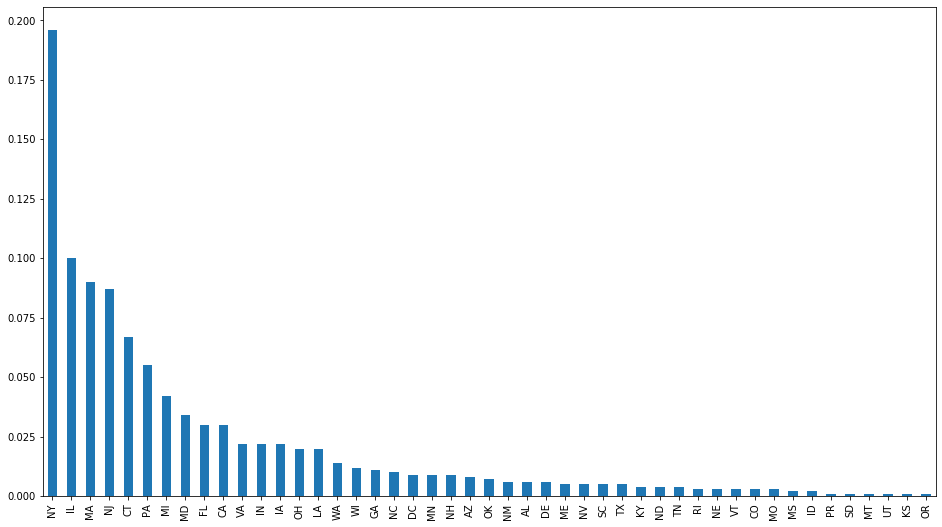

In [11]:
df2.state.value_counts(normalize=True).plot(kind='bar',  figsize=(16, 9))

In [12]:
my_tab = pd.crosstab(index=df2["state"],  # Make a crosstab
                              columns="count") 

#my_tab

## world cloud

In [13]:

# Load the regular expression library
import re
# Remove punctuation
df2['memo_processed'] = df2['memo'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df2['memo_processed'] = df2['memo_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
df2['memo_processed'].head()

0                        auditor in silicon valley
1             great-grandmother with an easy laugh
2    wife with little time to enjoy a new marriage
3                               sharecropper’s son
4          cancer survivor born in the philippines
Name: memo_processed, dtype: object

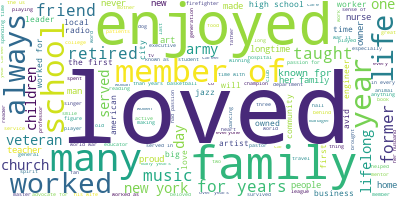

In [14]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df2['memo_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=150, contour_width=5, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## top 10 words

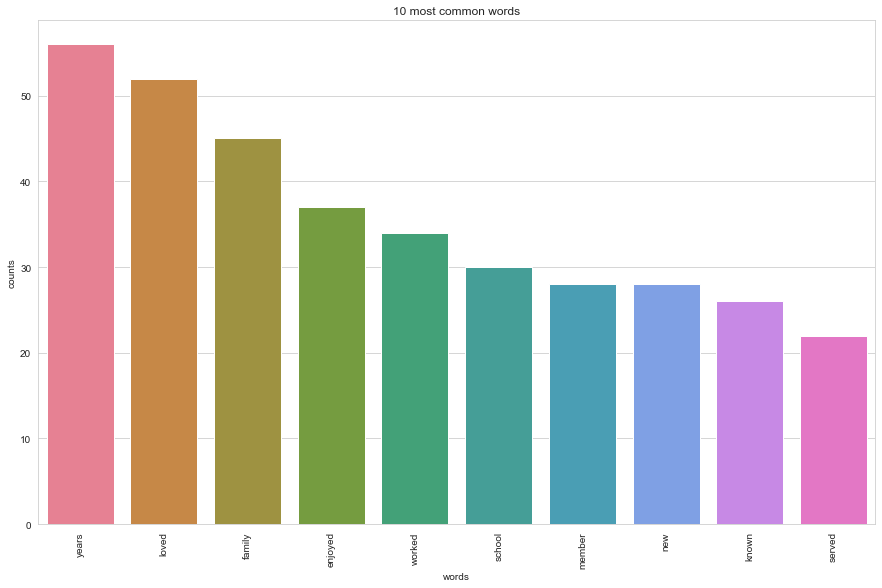

In [15]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df2['memo_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)



## top 5 topics through LDA (Latent Dirichlet Allocation)

In [18]:
import warnings
import os
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

os.chdir('C:/Users/Dexter/Downloads')

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
enjoyed family music known served passion member school master teacher

Topic #1:
new years york family career long avid retired member time

Topic #2:
worked years worker children career year man department enjoyed lifelong

Topic #3:
years veteran family member war great army proud art nurse

Topic #4:
loved known police school years life women animals enjoyed taught


In [20]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
LDA_data_filepath = os.path.join('./nyt_memo'+str(number_topics))

LDA_nyt_memo = sklearn_lda.prepare(lda, count_data, count_vectorizer)

pyLDAvis.save_html(LDA_nyt_memo, './nyt_memo'+ str(number_topics) +'.html')

Wall time: 2.84 s
